# Objective
### The aim of this notebook is to do exponential fitting on the image data to estimate the PD and the T2 values of mri scan

In [1]:
import os
import sys
from bart import bart#required for importing bart
import cfl#for reading and writing data in bart compatible format

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy.optimize
#%matplotlib inline

In [2]:
image_mask = np.load('subject2/Subject2_mask_experimental.npy')
pics_out_ksp = cfl.readcfl('pics_out_ksp').squeeze()


#for picking points from the center of k-space data
pics_out_ksp_undersampled = np.zeros(pics_out_ksp.shape,dtype=complex)
# pics_out_ksp_undersampled[132:156,132:156] = pics_out_ksp[132:156,132:156]
# pics_out_ksp_undersampled[120:168,120:168] = pics_out_ksp[120:168,120:168]
# pics_out_ksp_undersampled[72:216,72:216] = pics_out_ksp[72:216,72:216]
pics_out_ksp_undersampled = pics_out_ksp

# ## for randomly shuffling the sampling points in both dimensions
# random_PE_selector = np.zeros((288,288), dtype=int)
# Num_phase_encodes = 36
# half_pes = np.floor(Num_phase_encodes/2).astype('int')
# random_PE_selector[144-half_pes:144+half_pes,144-half_pes:144+half_pes] = 1
# plt.imshow(random_PE_selector, cmap='gray', vmax = .5,vmin=0)
# plt.show()
# random_PE_selector = random_PE_selector.ravel()
# np.random.shuffle(random_PE_selector)
# random_PE_selector = random_PE_selector.reshape(288,288)
# plt.imshow(random_PE_selector, cmap='gray', vmax = .5,vmin=0)
# plt.show()
# for index in range(pics_out_ksp.shape[-1]):
#     pics_out_ksp_undersampled[...,index] = pics_out_ksp[...,index]*random_PE_selector



pics_out  = bart(1,'fft -u 3', pics_out_ksp_undersampled)
print('Shape of the input data',pics_out.shape)
brain_images = pics_out.squeeze()
print('Brain_images shape:- ',brain_images.shape)
nonzero_data =  brain_images[np.nonzero(image_mask)]
print('Shape of nonzero data in the brain images:-',nonzero_data.shape)

Shape of the input data (288, 288, 16)
Brain_images shape:-  (288, 288, 16)
Shape of nonzero data in the brain images:- (35818, 16)


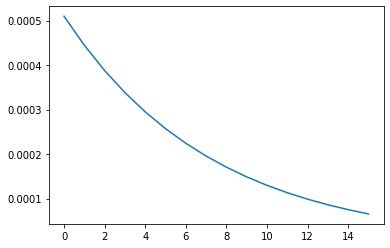

In [3]:
plt.plot(np.abs(nonzero_data[2500,:]))
plt.show()

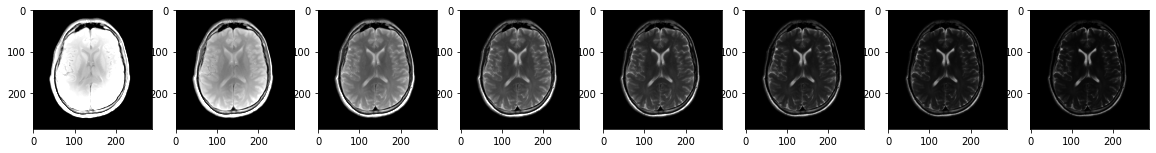

Brain images as acquired on different echoes


In [4]:
for index in range(8):
    plt.figure(1, figsize=(20,5))
    plt.subplot(1, 8, index+1)
    plt.imshow(np.abs(brain_images[:,:,2*index]),cmap=plt.get_cmap('gray'),vmin=0,vmax = .0005)
plt.show()
print('Brain images as acquired on different echoes')

In [5]:
def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

In [6]:
# #for running simultaneously
# T2_evaluated = np.zeros(nonzero_data.shape[0])
# PD_evaluated = np.zeros(nonzero_data.shape[0])
# TEs = (np.arange(16) +1)*18.2
# for index in tqdm(range(nonzero_data.shape[0])):
#     # perform the fit
#     single_pixel_data = np.abs(nonzero_data[index,:])
#     inital_guess = (0.01, .01, 0) # start with values near those we expect
#     params, cv = scipy.optimize.curve_fit(monoExp, TEs, single_pixel_data, inital_guess, maxfev=5000)
#     m, t, b = params
#     T2_evaluated[index] = 1/t
#     PD_evaluated[index] = m

In [7]:
#for parallel computing
def myfun(single_pixel_data):
    inital_guess = (0.001, .01, 0) # start with values near those we expect
    TEs = (np.arange(16) +1)*18.2
    params, cv = scipy.optimize.curve_fit(monoExp, TEs, single_pixel_data, inital_guess, maxfev=15000)
    return params

In [8]:
par_jobs = 32
from multiprocessing import Pool
with Pool(par_jobs) as p:
    result_dict = list((tqdm(p.imap(myfun, np.abs(nonzero_data)), total=len(nonzero_data), leave=True)))

  0%|          | 0/35818 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  3%|▎         | 1092/35818 [00:00<00:03, 10759.93it/s]/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
  7%|▋         | 2582/35818 [00:00<00:02, 11714.68it/s]/home/ubuntu/anaconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of t

In [9]:
X_sim3 = np.array(result_dict)
print(X_sim3.shape)
T2_evaluated = 1/X_sim3[:,1]
PD_evaluated = X_sim3[:,0]
residuals = X_sim3[:,2]

(35818, 3)


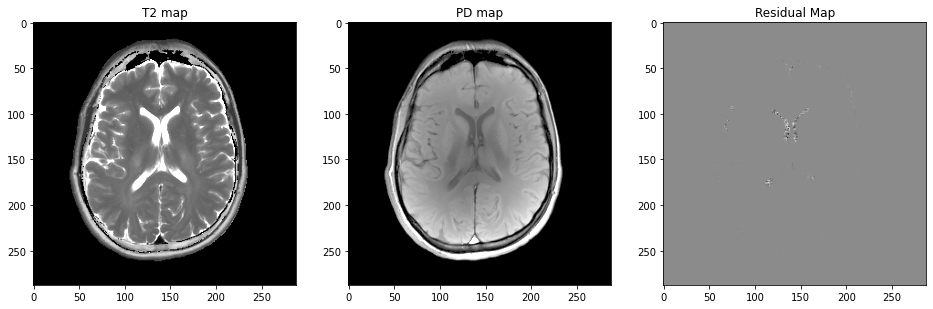

In [10]:
T2_maps = np.zeros((288,288))
PD_maps = np.zeros((288,288))
Residual_map = np.zeros((288,288))
T2_maps[np.nonzero(image_mask)] = T2_evaluated
PD_maps[np.nonzero(image_mask)] = PD_evaluated
Residual_map[np.nonzero(image_mask)] = residuals
plt.figure(figsize=(16,6))
plt.subplot(1,3,1)
plt.imshow(T2_maps, cmap='gray', vmin=0, vmax = 200)
plt.title('T2 map')
plt.subplot(1,3,2)
plt.imshow(PD_maps, cmap='gray', vmax = .001,vmin=0)
plt.title('PD map')
plt.subplot(1,3,3)
plt.imshow(Residual_map, cmap='gray')#, vmax = .001,vmin=0)
plt.title('Residual Map')
plt.show()